# Agenda
## A. Polygenic Risk Scores in Python
1. 	30 min: Overview of PRS and pipeline
2.	30 min: Discussion of Graham Coops tea drinking paper and others, with an emphasis on the ethics and limitations of PRS
3. 	10 min: Summary values to conduct a PRS
4.	10 min: Activity: Calculate and visualize


#### Resource for advanced learning: 

The followings tutorials, links given below, takes you through more details steps in calculating PRS. They all require Plink (which we are not using) and walks you through QC steps for this type of data and analysis. We are using a simplified summary statistic to calculate and visualize PRS, but if you are interested in a 'deeper dive' into this field, I think these are **reasonably** accessible tutorials. 
1. https://kcniconfluence.camh.ca/display/GEN/Tutorial+for+Polygenic+Risk+Score+Analysis
2. https://victor-moreno.github.io/PRS_tutorial/
3. https://github.com/PGScatalog/pgsc_calc/

Polygenic risk score(PRS), as known as polygenic score (PGS) or genetic risk score (GRS), is a score that summarizes the effect sizes of genetic variants on a certain disease or trait (weighted sum of disease/trait-associated alleles). This score is calculated by summing the contributions of risk alleles carried by the individual, each weighted by its respective effect size as determined by a Genome-Wide Association Study (GWAS) specific to the phenotype in question.

---
__PGS__: A single value that quantifies an individual's genetic predisposition to a trait

__PRS__: A subset of PGS that is used to estimate the risk of diseae or other clinically relevant outcomes (binary or discrete). 

To calculate the PRS for sample j,

$PRS_j = \sum_{i=0}^{i=M} x_{i,j} \hat{\beta}_{i}$

$(\hat{\beta}_i)$ : effect size for variant $(i)$

$(x_{i,j})$ : the effect allele count for sample $(j)$ at variant $(i)$. This is a genetic matrix will rows $i$ = 1...n and columns $j$=1...m for n indiviudals and m bi-allelic genetic variants (coded at 0,1, and 2 for the number of non-reference alleles present). 

$(M)$ : the number of variants

https://victor-moreno.github.io/PRS_tutorial/
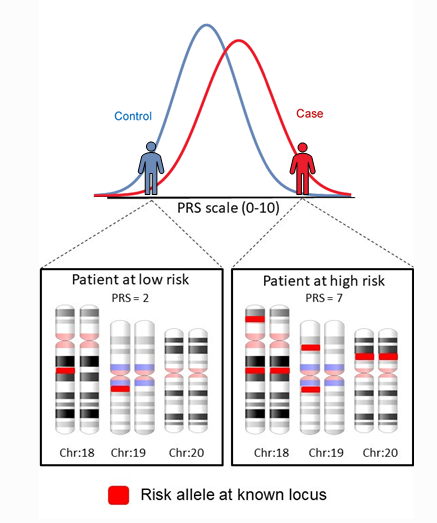


https://www.researchgate.net/figure/Basic-stepwise-process-for-calculating-PGS-Effect-sizes-weights-of-single-nucleotide_fig1_359609490



### PRS Analysis Workflow
* Developing PRS model using base data
  * check heritability of SNP (must be >0.05)
* Performing validation to obtain best-fit parameters
* Evaluation in an independent population
  * target and base population must have same effect allele

A common model is based on __p-values__ and is called "Pruning + Thresholding" (or sometimes "Clumping and thresholding"). 

Before calculating PRS, the variants are first clumped, and variants that are weakly correlated $(r^2)$ with one another are retained. The clumping step prunes redundant correlated effects caused by linkage disequilibrium (LD) between variants and is important when there are multiple significant association in high LD in the same region. Thresholding will remove variants with a p-value larger than a chosen level of significance (default: 0.0001).

http://www.pgscatalog.org/

Here is a tutorial (Dec 4, 2024) that explains how to use the information in the https://www.pgscatalog.org/

---
https://embl-ebi.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=274f9879-258d-4570-be9e-b23c011e72cd


This is a still from the tutorial link above. Let's walk through it since it identifies the main concept behind PRS (although not yet the major problem):
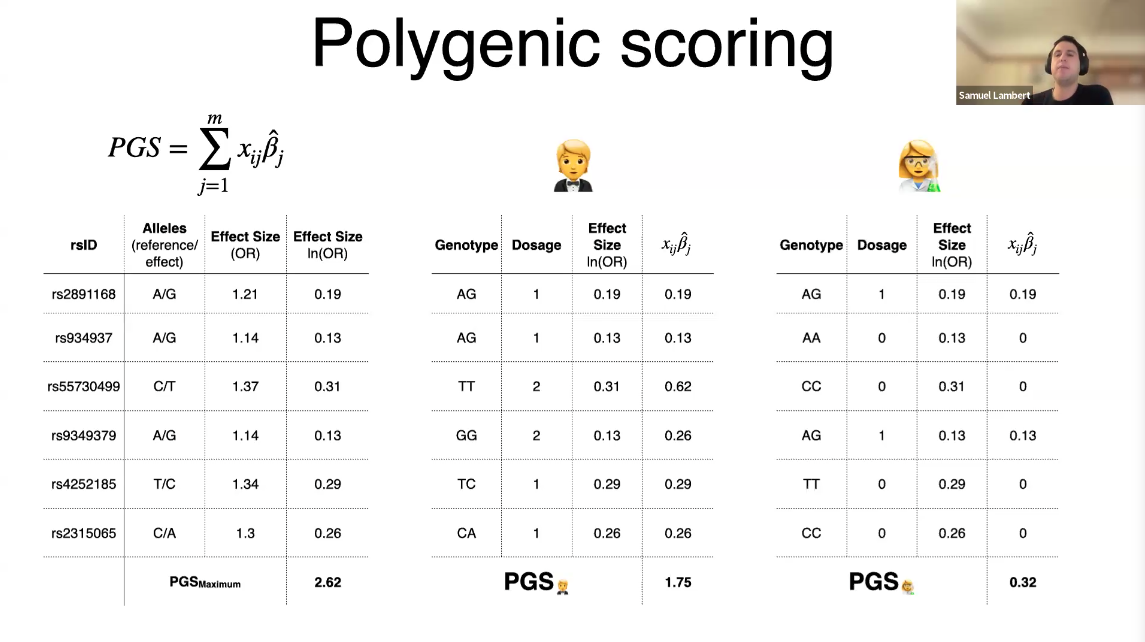

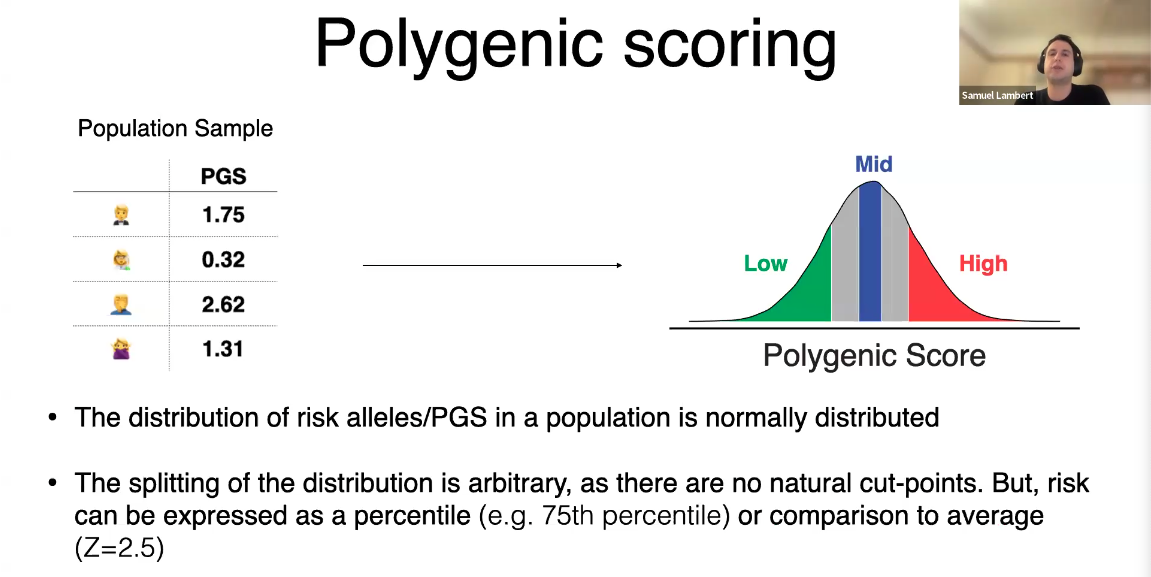

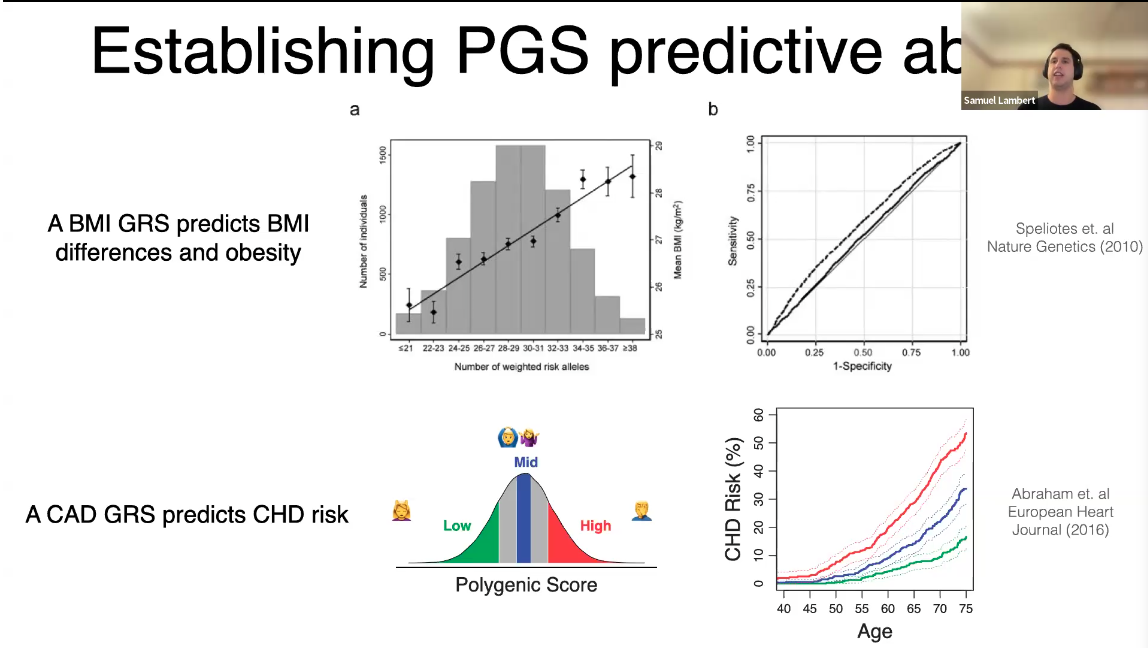

* If you train on one population ancestry (typically European) for your GWAS, then when you try to generalize and develop scores for individuals from other ancestries (other contexts), you have problems!
* This is nuanced because ancestries are constraints (that is: 'races' are not genetically real, but allele frequences can differ between ancestries and that is where the problem arises).
* I have included a number of papers discussing this in your syllabus. Here are some of the major ones:
  1. https://www.nature.com/articles/538161a
  2. https://www.nature.com/articles/s41588-019-0379-x
  3. https://pmc.ncbi.nlm.nih.gov/articles/PMC9808501/
  4. https://arxiv.org/abs/1909.00892
  5. https://www.medrxiv.org/content/10.1101/2024.06.13.24308905v1
     
 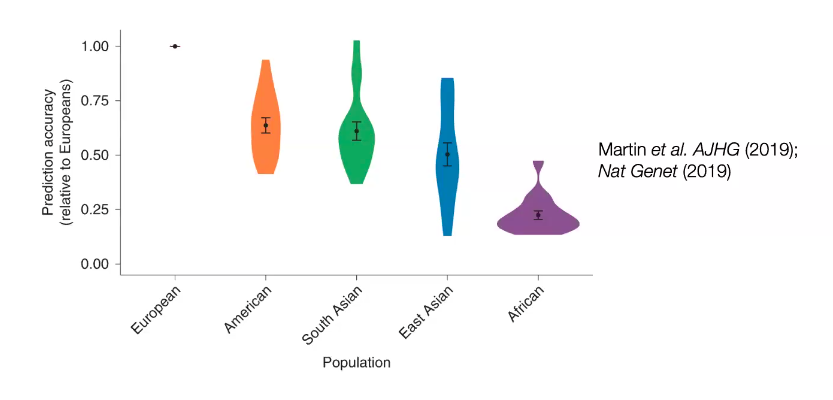


The following calculation is a **simplification** of how you would calculate a legitimate PRS (the links to several tutorials at the top of this notebook give you the more sophisticated calculations for legitimate PRS). We will find the PGS score for our particular trait/disease of interest and calculate the $PGS_{max}$ score. 


In [1]:
# import the stack!
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# you might have a different number of rows to skip depending on your characteristic
alz=pd.read_table("alz_PGS.txt",delimiter='\t',skiprows=14)
print(alz)
print("~~~~~~~~~~")
# there is something weird here - the effect_weight contain some negative values. This means that in these
# cases individuals are less likely to have the disease! 
# There are a number of ways that this could happen. 
# risk allele in one population - used to get GWAS- could be 'protective' in another (the target population)
# this could include a different target ancestry than the the variants were identified in 
# these variants are epistatic instead of additive effects
# missing or imputed data -- potentially inaccurate

           rsID  chr_name  chr_position effect_allele  effect_weight  \
0     rs4844610         1     207802552             A         0.1466   
1      rs876461         2      37515958             G        -0.0744   
2     rs6733839         2     127892810             C        -0.1693   
3    rs10933431         2     233981912             G        -0.1001   
4     rs4351014         4      11027619             T         0.0676   
5     rs9275152         6      32652196             T         0.1319   
6   rs143332484         6      41129207             C        -0.4950   
7    rs75932628         6      41129252             C        -0.6989   
8     rs9381040         6      41154650             C         0.0590   
9     rs9381564         6      47443806             A        -0.0830   
10    rs1859788         7      99971834             A        -0.0652   
11   rs56402156         7     143103481             G         0.1024   
12   rs73223431         8      27219987             C        -0.

In [20]:
# I went into the same PGS number: 000025 ocated here https://www.pgscatalog.org/score/PGS000025/
# and downloaded a newer PGS. These do not have negative numbers, but they trained and applied in the same ancestry
alz2=pd.read_table("PGS000025.txt",delimiter='\t',skiprows=14)
print(alz2)
print("~~~~~~~~~~")
alz2["ln(OR)"]=np.log(alz2["OR"])
print(alz2)
print("You will notice that the ln(OR) is the weight effect column!")

          rsID  chr_name  chr_position effect_allele other_allele  \
0    rs6656401         1     207692049             A            G   
1    rs6733839         2     127892810             T            C   
2   rs35349669         2     234068476             T            C   
3     rs190982         5      88223420             A            G   
4    rs9271192         6      32578530             C            A   
5   rs10948363         6      47487762             G            A   
6    rs2718058         7      37841534             A            G   
7    rs1476679         7     100004446             T            C   
8   rs11771145         7     143110762             G            A   
9   rs28834970         8      27195121             C            T   
10   rs9331896         8      27467686             T            C   
11  rs10838725        11      47557871             C            T   
12    rs983392        11      59923508             A            G   
13  rs10792832        11      8586

In [21]:
type(alz2)
alz2.columns

Index(['rsID', 'chr_name', 'chr_position', 'effect_allele', 'other_allele',
       'effect_weight', 'allelefrequency_effect', 'locus_name', 'OR',
       'ln(OR)'],
      dtype='object')

<Axes: >

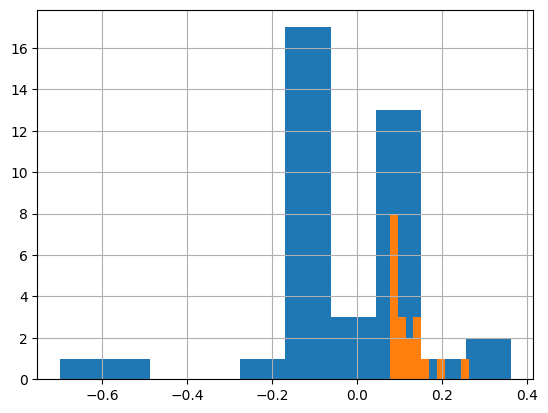

In [23]:
# Strategy: take column 4 - the 5th column - and take the log of it, multiply it by 2
#(if both effect alleles were inherited) and add them all up
alz['effect_weight'].hist()
alz2["effect_weight"].hist()

In [31]:
Alz_PGS_max=alz['effect_weight'].sum()
print(Alz_PGS_max*2)

-2.0963999999999996


In [24]:
Alz2_PGS_max=alz2['effect_weight'].sum()
print(Alz2_PGS_max*2)

4.637789806
